In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px
import plotly.graph_objects as go
from fbprophet import Prophet
import chart_studio
import chart_studio.plotly as py
import dash
import dash_core_components as dcc
import dash_html_components as html

In [54]:
chart_studio.tools.set_credentials_file(username='ralhusban', api_key='0F7vaylJaEkkbwUk3SLi')

## Import New York Times's dataset, parse date parameter makes sure the dates are in the proper format, it also helps us to work on this dataset as time series.
The advantage of importing a dataset directly from a URL is that you'll always get an up to date infromation on COVID-19

In [2]:
covid_df=pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-states.csv', parse_dates=True)
covid_df_counties=pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv', parse_dates=True)

In [3]:
#Checking that the dataset is imported correctly and looks good
covid_df.head()

date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0
3  2020-01-24    Illinois    17      1       0
4  2020-01-24  Washington    53      1       0

In [4]:
#Dropping the 'fips' column as it is meant for geolocation info, which I'm not using in my analysis (so far)
#covid_df.drop('fips', axis=1, inplace=True)

## This code uses the groupby and sort functions to plot infections and deaths in each state by descending order. We clearly see that New York and New Jersey dwarf other states.

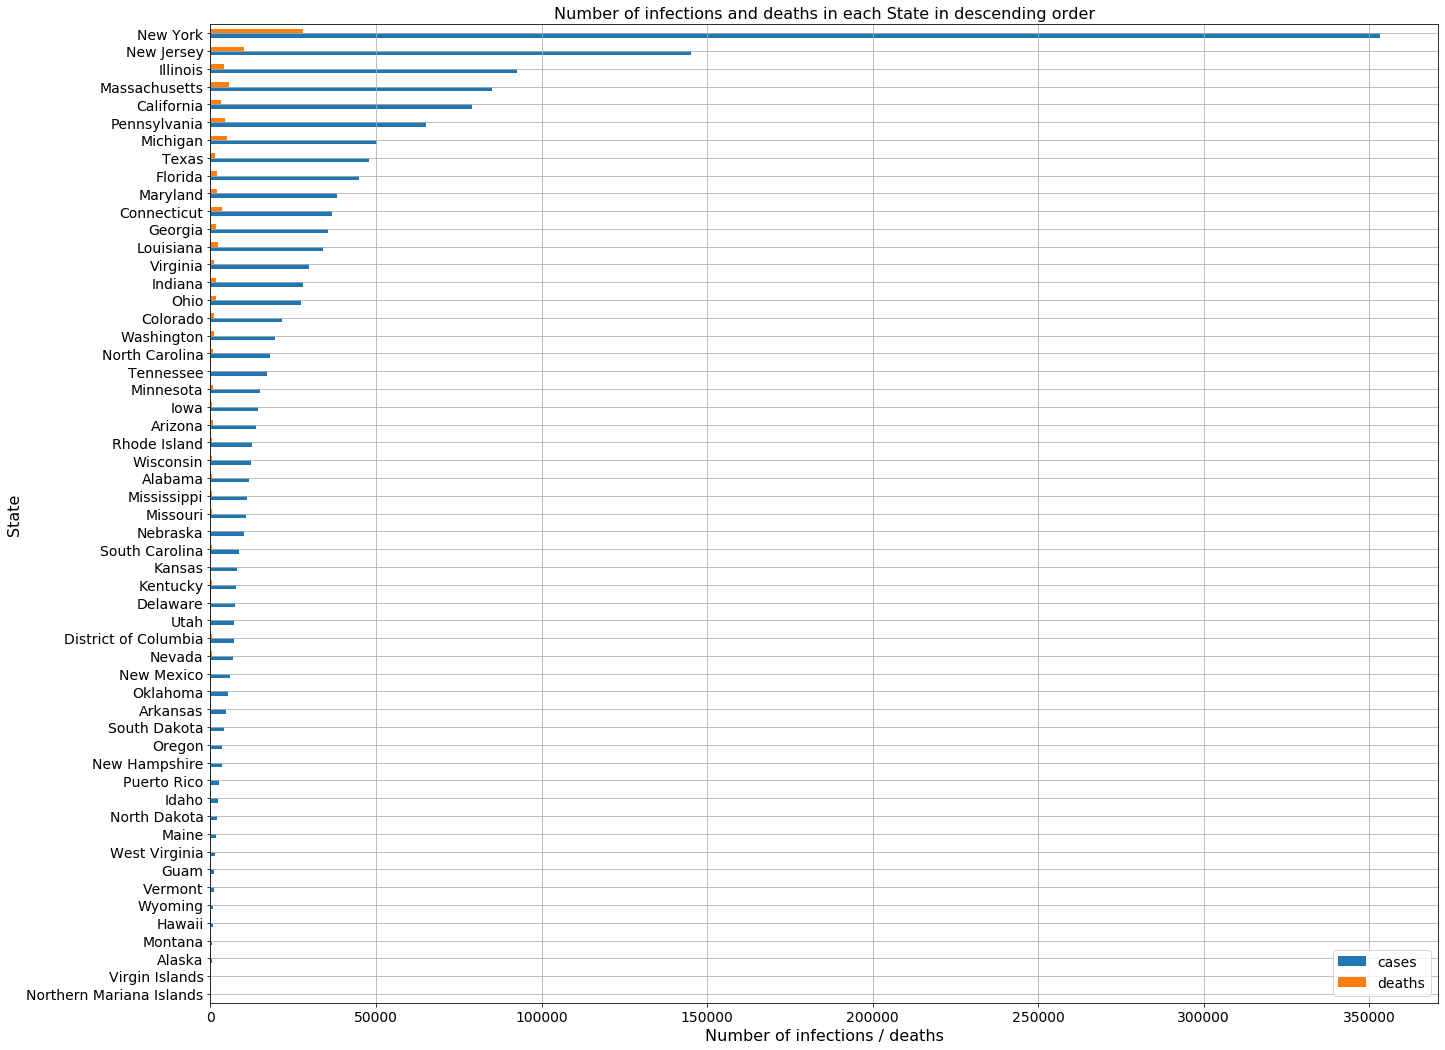

In [5]:

covid_df[['state','cases','deaths']].groupby('state').last().sort_values('cases',ascending=True).plot\
(kind='barh', figsize=(22,18), grid=True, fontsize=14)
plt.ylabel('State', fontsize=16)
plt.xlabel('Number of infections / deaths', fontsize=16)
plt.title('Number of infections and deaths in each State in descending order', fontsize=16)
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [6]:
#covid_df[['date','state','cases','deaths']].groupby('state').sum().plot(kind='bar', figsize=(25,15))

In [7]:
#ax1=plt.gca()
#covid_df[covid_df['state']=='New York'][['state','cases', 'date']].loc[:].plot(x='date', figsize=(25,15), dashes=[2,2], alpha=0.8, ax=ax1, label='New York', grid=True)
#covid_df[covid_df['state']=='New Jersey'][['state','cases', 'date']].loc[:].plot(x='date', figsize=(25,15), dashes=[2,2], alpha=0.8, ax=ax1, label='New Jersey', grid=True)
#ax1.legend()
#plt.show()
#covid_df[covid_df['state']=='Washington'].loc[800:].plot(x='date', figsize=(25,15), kind='line', alpha=0.5, ax=ax1)

## Creating a new dataframe with New York data for separate analysis

In [8]:
NY_df=covid_df[covid_df['state']=='New York'][['state','cases', 'deaths', 'date']]
VA_df=covid_df[covid_df['state']=='Virginia'][['state','cases', 'deaths', 'date']]

In [9]:
#Copying the date column to the index and dropping the date column which reduces the size of our dataframe and makes it easier to read
NY_df.index=NY_df.date
VA_df.index=VA_df.date
NY_df.drop(columns='date', inplace=True)
VA_df.index=VA_df.date
VA_df.drop(columns='date', inplace=True)

In [10]:
NY_df.tail(10)

state   cases  deaths
date                                
2020-05-07  New York  332931   26206
2020-05-08  New York  335804   26358
2020-05-09  New York  338519   26584
2020-05-10  New York  340657   26798
2020-05-11  New York  342267   27003
2020-05-12  New York  343705   27282
2020-05-13  New York  345828   27448
2020-05-14  New York  348192   27617
2020-05-15  New York  350951   27755
2020-05-16  New York  353136   27953

In [11]:
#NY_df.index.astype('datetime64[ns]')

## Plotting cumulative cases in New York State

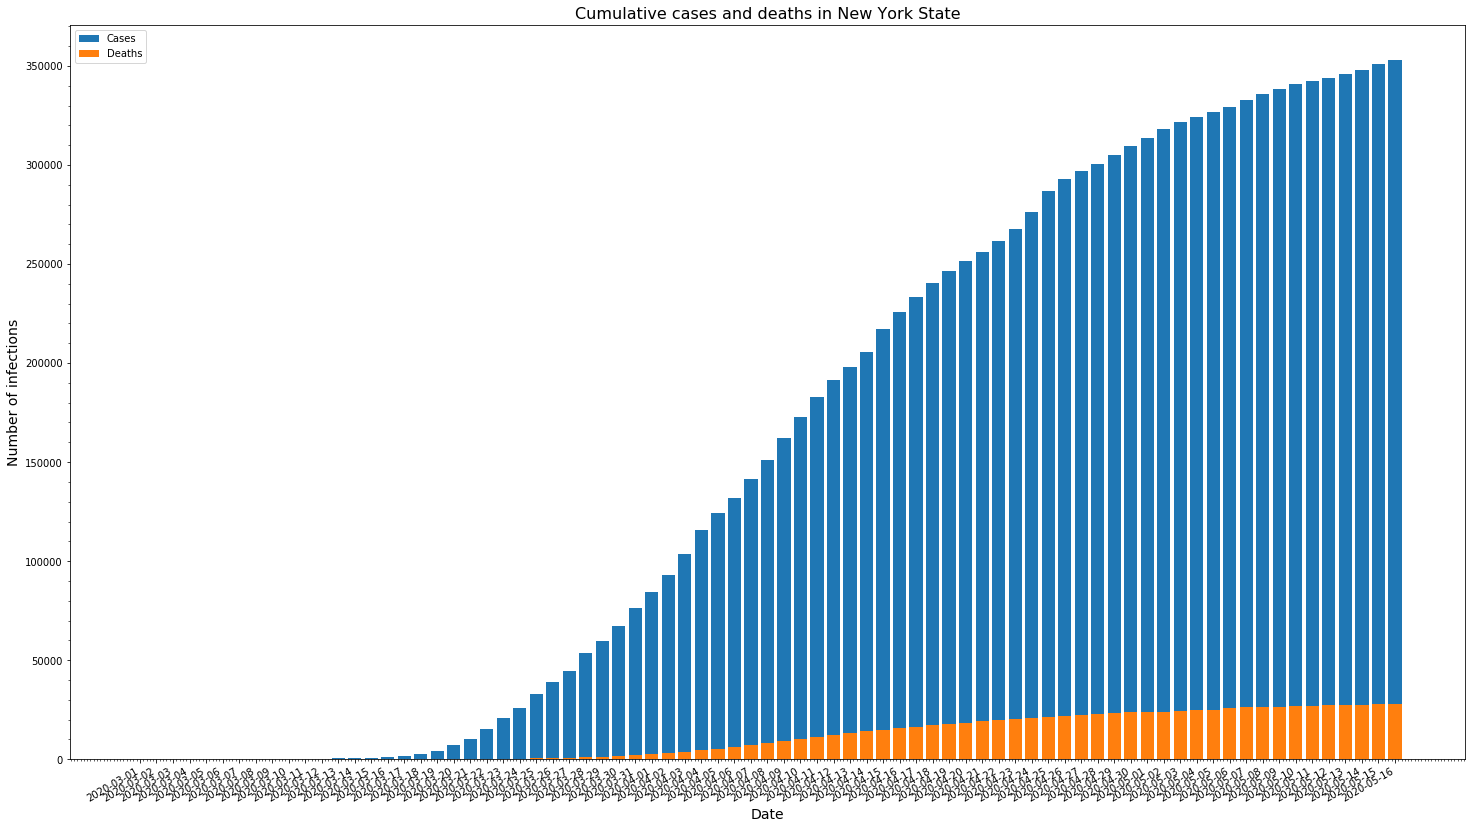

In [12]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(NY_df.index, NY_df.cases, label='Cases')
ax.bar(NY_df.index, NY_df.deaths, label='Deaths')
plt.legend()
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of infections', fontsize=14)
plt.title('Cumulative cases and deaths in New York State', fontsize=16)
plt.minorticks_on()
plt.show()

## Since daily fluctuations in number of infections and deaths could confuse analysis, we use below a statistical method of rolling or moving averages to calculate short and long averages which take into account a 3 and a 7 day rolling averages. We will plot the results separately and we can observe that the longer the rolling window, the smoother are the lines that reflect daily cases.

In [13]:

NY_rollshort=NY_df.cases.rolling(window=3)
NY_rolllong=NY_df.cases.rolling(window=7)
NY_df['SMA_short']=NY_rollshort.mean()
NY_df['SMA_long']=NY_rolllong.mean()
NY_df['New_cases']=0
NY_df['New_cases_Short_MA']=0
NY_df['New_cases_Long_MA']=0
NY_df['New_deaths']=0



In [14]:
VA_rolllong=VA_df.cases.rolling(window=7)
VA_df['SMA_long']=VA_rolllong.mean()
VA_df['New_cases']=0
VA_df['New_cases_Long_MA']=0
VA_df['New_deaths']=0

In [15]:
#Veryfying the dataset lenght
#len(NY_df)
#NY_df.loc[:,('cases')][2]

## Update: The below forloop is disabled as it would be inefficient in large datasets to loop thru the whole data. A simple Panda method 'diff()' does the same job of calculate difference between rows.
## The below code 'For loop'(now disabled) is done to calculate daily new cases of infections and deaths since the data set provides cumulative daily case. Hence a simple for loop is done to calculate the difference in infections between a day and the preceding day for infections and deaths. The same is done for the 3 and 7 day averages.

In [16]:
NY_df.New_cases=NY_df.cases.diff()
NY_df.New_cases_Short_MA=NY_df.SMA_short.diff()
NY_df.New_cases_Long_MA=NY_df.SMA_long.diff()
NY_df.New_deaths=NY_df.deaths.diff()
NY_df.fillna(0, inplace=True) # Replacing null values with zeros in the dataset to avoid any issues with visualization libraries

In [17]:
VA_df.New_cases=VA_df.cases.diff()
VA_df.New_cases_Long_MA=VA_df.SMA_long.diff()
VA_df.New_deaths=VA_df.deaths.diff()
VA_df.fillna(0, inplace=True)

In [18]:
# Disabled forloop code kept for reference. It was replaced by the more efficient diff() method
#for i in range(len(NY_df)):
#    if NY_df.cases[i]==1:
#        i+=1
#    else:
#        NY_df.New_cases[i]=NY_df.cases[i]-NY_df.cases[i-1]
#        NY_df.New_deaths[i]=NY_df.deaths[i]-NY_df.deaths[i-1]
#        NY_df.New_cases_Short_MA[i]=NY_df.SMA_short[i]-NY_df.SMA_short[i-1]
#        NY_df.New_cases_Long_MA[i]=NY_df.SMA_long[i]-NY_df.SMA_long[i-1]

In [19]:
NY_df.cases[-1]

353136

## We plot the daily new cases of infections and deaths in New York State using matplotlib. In order to metigate day-to-day fluctuations, the blue line tracks a 7-days rolling average of new infections to show a more general trend of the 'curve' which appears to be on the downward trend since April 15. A few texts combined with variables are also plotted on the chart to reflect important changes such as change in new infections and deaths. 
## Note the surge in death cases on May 6 - This is caused by the NYT starting to report probable COVID-19 related deaths and not only the ones confirmed by testing.

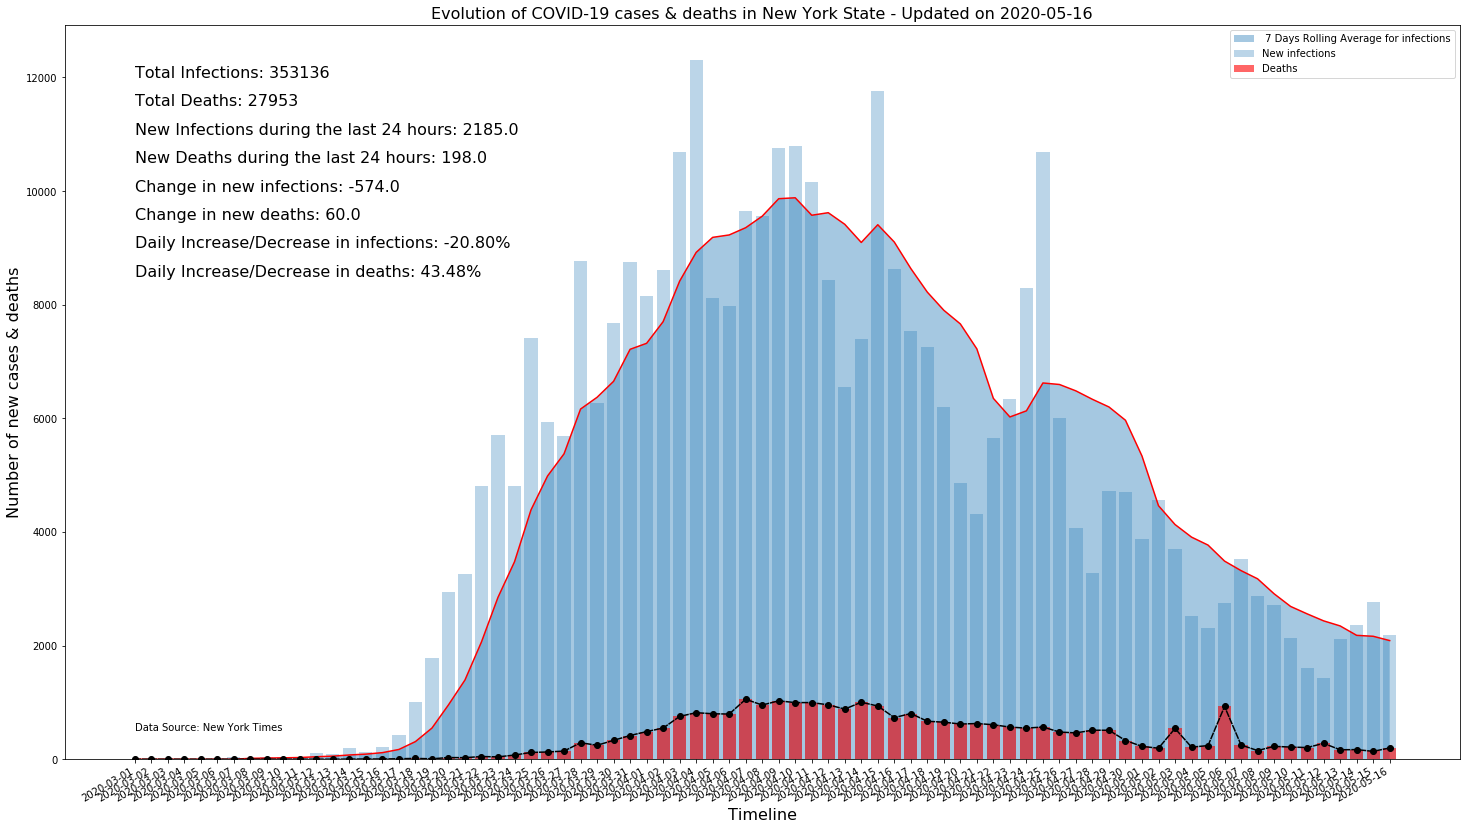

In [20]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(NY_df.index, NY_df.New_cases, alpha=0.3, label='New infections')
ax.bar(NY_df.index, NY_df.New_deaths, alpha=0.6, color='red', label='Deaths')
ax.stackplot(NY_df.index, NY_df.New_cases_Long_MA, labels=[' 7 Days Rolling Average for infections'], alpha=0.4 )
ax.plot(NY_df.index, NY_df.New_cases_Long_MA, color='red')
ax.plot(NY_df.index, NY_df.New_deaths, 'ko--', dash_capstyle='projecting' )
ax.text(0,12000,s='Total Infections: '+str(NY_df.cases[-1]), fontsize=16)
ax.text(0,11500,s='Total Deaths: '+str(NY_df.deaths[-1]), fontsize=16)
ax.text(0,11000,s='New Infections during the last 24 hours: '+str(NY_df.New_cases[-1]), fontsize=16)
ax.text(0,10500,s='New Deaths during the last 24 hours: '+str(NY_df.New_deaths[-1]), fontsize=16)
ax.text(0,10000,s='Change in new infections: '+str(NY_df.New_cases[-1]-NY_df.New_cases[-2]), fontsize=16)
ax.text(0,9500,s='Change in new deaths: '+str(NY_df.New_deaths[-1]-NY_df.New_deaths[-2]), fontsize=16)
ax.text(0,9000,s='Daily Increase/Decrease in infections: '+'{0:.2f}'.format(((NY_df.New_cases[-1]-NY_df.New_cases[-2])/NY_df.New_cases[-2]*100))+'%', fontsize=16) # Note the use of the format() method to round the percentage decimals
ax.text(0,8500,s='Daily Increase/Decrease in deaths: '+'{0:.2f}'.format(((NY_df.New_deaths[-1]-NY_df.New_deaths[-2])/NY_df.New_deaths[-2]*100))+'%', fontsize=16)
ax.text(0,500,s='Data Source: New York Times')
fig.autofmt_xdate()
plt.xlabel('Timeline', fontsize=16)
plt.ylabel('Number of new cases & deaths', fontsize=16)
plt.legend()
plt.title('Evolution of COVID-19 cases & deaths in New York State - Updated on '+str(NY_df.index[-1]), fontsize=16)
plt.savefig('COVID19NYC.pdf', bbox_inches='tight') # This code saves the plot to a PDF file
plt.show()

## We do the same chart for the State of Virginia

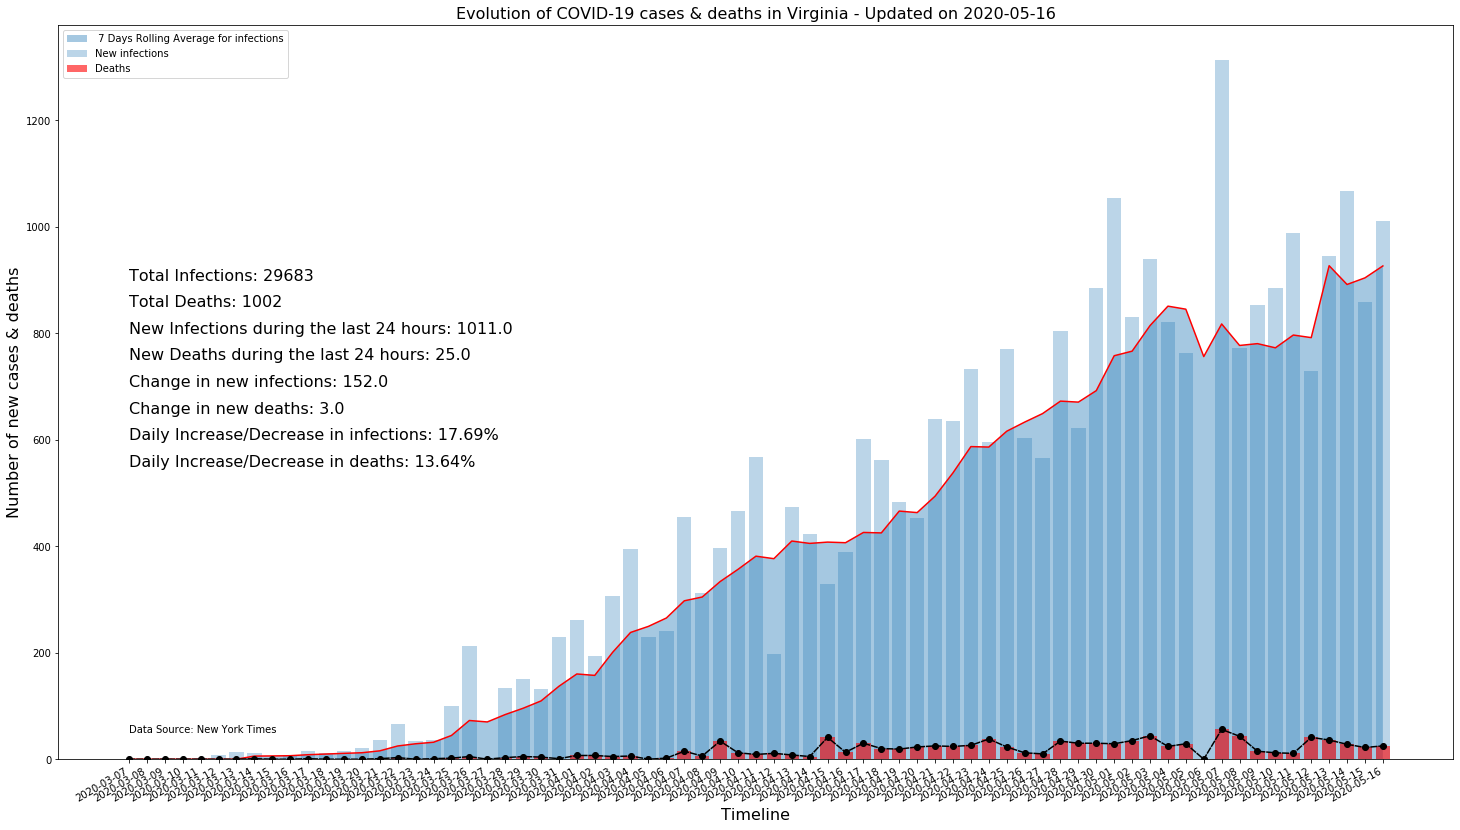

In [21]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(VA_df.index, VA_df.New_cases, alpha=0.3, label='New infections')
ax.bar(VA_df.index, VA_df.New_deaths, alpha=0.6, color='red', label='Deaths')
ax.stackplot(VA_df.index, VA_df.New_cases_Long_MA, labels=[' 7 Days Rolling Average for infections'], alpha=0.4 )
ax.plot(VA_df.index, VA_df.New_cases_Long_MA, color='red')
ax.plot(VA_df.index, VA_df.New_deaths, 'ko--', dash_capstyle='projecting' )
ax.text(0,900,s='Total Infections: '+str(VA_df.cases[-1]), fontsize=16)
ax.text(0,850,s='Total Deaths: '+str(VA_df.deaths[-1]), fontsize=16)
ax.text(0,800,s='New Infections during the last 24 hours: '+str(VA_df.New_cases[-1]), fontsize=16)
ax.text(0,750,s='New Deaths during the last 24 hours: '+str(VA_df.New_deaths[-1]), fontsize=16)
ax.text(0,700,s='Change in new infections: '+str(VA_df.New_cases[-1]-VA_df.New_cases[-2]), fontsize=16)
ax.text(0,650,s='Change in new deaths: '+str(VA_df.New_deaths[-1]-VA_df.New_deaths[-2]), fontsize=16)
ax.text(0,600,s='Daily Increase/Decrease in infections: '+'{0:.2f}'.format(((VA_df.New_cases[-1]-VA_df.New_cases[-2])/VA_df.New_cases[-2]*100))+'%', fontsize=16) # Note the use of the format() method
ax.text(0,550,s='Daily Increase/Decrease in deaths: '+'{0:.2f}'.format(((VA_df.New_deaths[-1]-VA_df.New_deaths[-2])/VA_df.New_deaths[-2]*100))+'%', fontsize=16)
ax.text(0,50,s='Data Source: New York Times')
fig.autofmt_xdate()
plt.xlabel('Timeline', fontsize=16)
plt.ylabel('Number of new cases & deaths', fontsize=16)
plt.legend()
plt.title('Evolution of COVID-19 cases & deaths in Virginia - Updated on '+str(VA_df.index[-1]), fontsize=16)
plt.savefig('COVID19VA.pdf', bbox_inches='tight') # This code saves the plot to a PDF file
plt.show()

## The below chart is generated with Plotly Express library, with a main advantage that it's an interactive chart and easy to generate mainly inteded for tidy date! Just hover the mouse over the bard and you will be able to read the details of each day & many other functions!

In [22]:
fig = px.bar(data_frame=NY_df, x=NY_df.index, y='New_cases', title='New COVID-19 case in New York', width=1400, height= 800)
fig.show()

## This chart is done using the standard Plotly library using the 'go.Figure' method. This was allows us to use multiple layers as illustrated-below

In [55]:
fig=go.Figure()
fig.add_trace(go.Bar(x=NY_df.index, y=NY_df.New_cases, name='Infections'))
fig.add_trace(go.Bar(x=NY_df.index, y=NY_df.New_deaths, name='Deaths'))
fig.add_trace(go.Scatter(x=NY_df.index, y=NY_df.New_cases_Long_MA, name='7-Days rolling average'))
fig.update_layout(title='Daily new infections and deaths in New York State', xaxis_title='Timeline', yaxis_title='Number of new infections & deaths',  width=1400, height= 800)
py.plot(fig, filename='NY_Covid19')


'https://plotly.com/~ralhusban/12/'

## Below is a simple use of the Panda Groupby function with sorting parameter. Notice that we use the 'last()' method to use the last row of each group since our dataset has cumulative COVID-19 infections in its rows.

In [24]:
#Total cases & deaths by State sorted descending

covid_df[['state','cases','deaths']].groupby('state').last().sort_values('cases',ascending=False)

cases  deaths
state                                   
New York                  353136   27953
New Jersey                145089   10249
Illinois                   92669    4149
Massachusetts              84933    5705
California                 78933    3254
Pennsylvania               65228    4490
Michigan                   50416    4880
Texas                      47866    1330
Florida                    44803    1963
Maryland                   38083    1957
Connecticut                36703    3339
Georgia                    35655    1573
Louisiana                  34117    2413
Virginia                   29683    1002
Indiana                    27919    1741
Ohio                       27476    1610
Colorado                   21604    1192
Washington                 19426    1015
North Carolina             18009     671
Tennessee                  17204     292
Minnesota                  14978     709
Iowa                       14328     346
Arizona                    13631     679
Rhode Island               12434     489
Wisconsin                  12368     453
Alabama                    11674     485
Mississippi                11123     510
Missouri                   10794     595
Nebraska                   10220     129
South Carolina              8661     380
Kansas                      8060     189
Kentucky                    7773     346
Delaware                    7547     286
Utah                        7068      78
District of Columbia        7042     375
Nevada                      6819     349
New Mexico                  5847     259
Oklahoma                    5237     288
Arkansas                    4578      98
South Dakota                3959      44
Oregon                      3612     137
New Hampshire               3556     171
Puerto Rico                 2589     122
Idaho                       2419      73
North Dakota                1848      42
Maine                       1648      70
West Virginia               1470      65
Guam                        1123       6
Vermont                      934      53
Wyoming                      741       7
Hawaii                       629      17
Montana                      468      16
Alaska                       392       8
Virgin Islands                69       6
Northern Mariana Islands      21       2

## Below is the Autocorrelation plot. Autocorrelation is a metric that measures how correlated is a given data or array. The closer it gets to zero the more correlated it is. Once the bars in the chart below sink in the blue shade, it means that there is a good possibility that the data is correlated or in other words its not random. I'm yet to analyse why would a pandemic data start with weak correlation and then tend to form a stronger correlation with time. My initial theory is that there is a stronger correlation simply because the pandemic 'curve' was just recently flattening and the correlation will start to weaken once numbers of infections starts to decrease. 

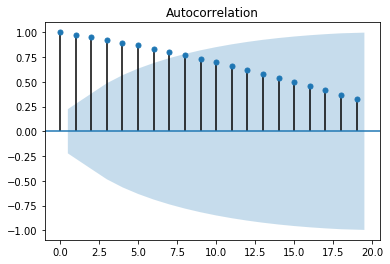

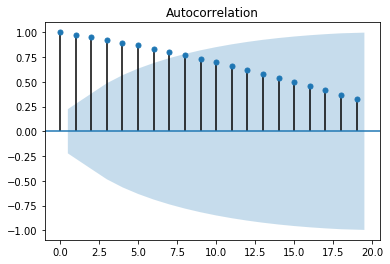

In [25]:
plot_acf(NY_df.cases)

## A word of caution on both models attempted below: The Data that trained the model is very limited to produce a reliable model. Also a significant downside is that our only variable is the number of new infections. More advances and successful models take into account many variables such as how a population adheres to social distancing, the R^0 of the contagion, etc.

## Below are two forecasting attempts using ARIMA and Facebook's Prophet libraty. Both seemed to be incompatible with epedimiological data. The ARMIA model went on an exponential increase as soon as we went with out of sample forcasting, while the 'Prophet' seemed to be using an incremental seasonal trent in forcasting future data making it a bad for such data.

## ARIMA

In [26]:
NY_df1=NY_df.iloc[2:] # I trimmed the DF here as rows with zero new cases create infinite values when logaritmizing data

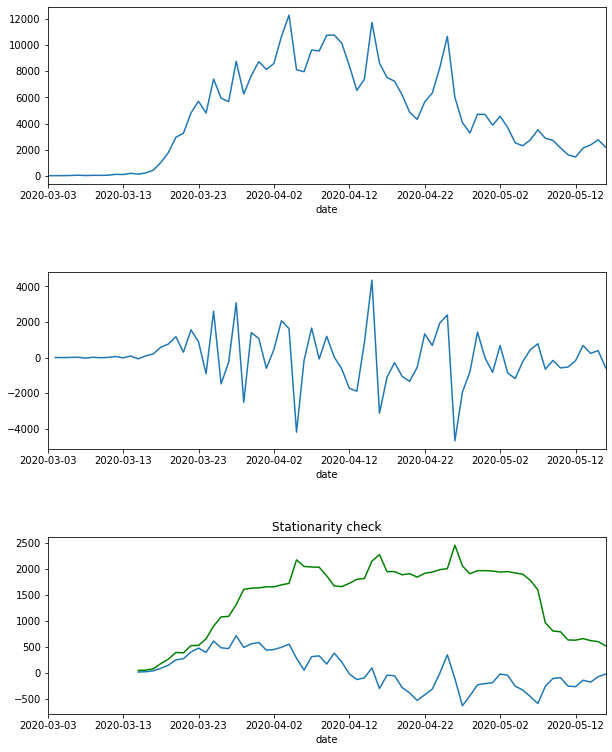

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 13))

# Plot the NY_DF_cases numbers
NY_df1.New_cases.plot(ax = ax1)

# Plot differentiated signal
NY_df1.New_cases.diff().plot(ax = ax2)

# PLot the moving average and moving standard deviation
NY_df1.New_cases.diff().rolling(12).mean().plot(ax = ax3, title = 'Stationarity check')
NY_df1.New_cases.diff().rolling(12).std().plot(ax = ax3, color = 'green')

# Plot
plt.subplots_adjust(hspace = 0.5)
plt.show()

In [28]:
NY_df1['New_cases_log'] = np.log(NY_df1['New_cases'])

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Despite logaritmizing the data, the signal was not very stationary and hence the model was behaving erratically

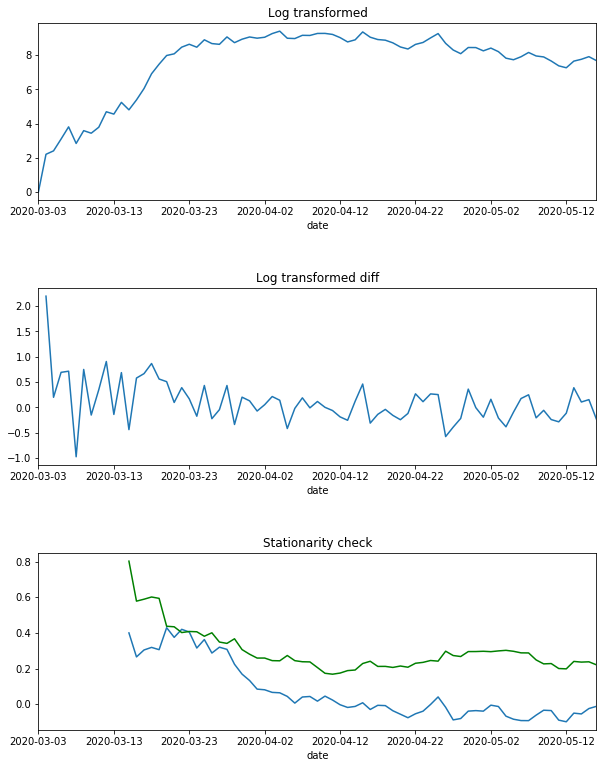

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 13))

# Plot the NY_DF_cases numbers
NY_df1.New_cases_log.plot(ax = ax1, title='Log transformed')

# Plot differentiated signal
NY_df1.New_cases_log.diff().plot(ax = ax2, title='Log transformed diff')

# PLot the moving average and moving standard deviation
NY_df1.New_cases_log.diff().rolling(12).mean().plot(ax = ax3, title = 'Stationarity check')
NY_df1.New_cases_log.diff().rolling(12).std().plot(ax = ax3, color = 'green')

# Plot
plt.subplots_adjust(hspace = 0.5)
plt.show()

In [30]:
n = np.int(len(NY_df1) * 0.7)
train, test = NY_df1.iloc[:n], NY_df1.iloc[n:]

## The below Autocorrelation and partial autocorrelation plot are needed to determine the order of the ARIMA fit, particularely the P and the Q paremeters. They are basically detemined by seeing the nearest AC and PAC to zero and hence in the example below we chose 15 for the P (c.f. the autocorrelation plot) value and 11 (c.f. see the partial autocorrelation plot) for the Q value

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



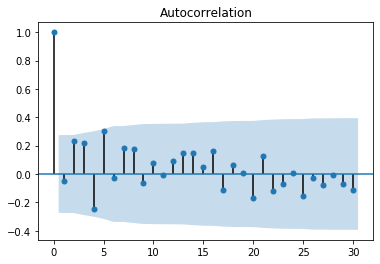

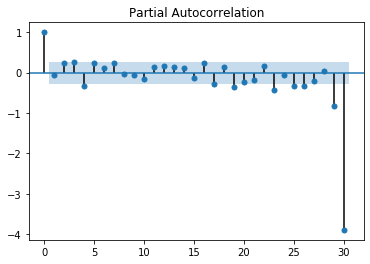

In [31]:
p1 = tsaplots.plot_acf(train.New_cases_log.diff().dropna(), lags=30, alpha=0.05)
p2 = tsaplots.plot_pacf(train.New_cases_log.diff().dropna(), lags=30, alpha=0.05)
plt.show()

In [32]:
arima = ARIMA(train.New_cases_log.dropna().astype(float), order=(10,1,1))
arima_fit = arima.fit(disp=-1, maxiter=500)
print(arima_fit.summary())

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                             ARIMA Model Results                              
Dep. Variable:        D.New_cases_log   No. Observations:                   51
Model:                ARIMA(10, 1, 1)   Log Likelihood                 -21.366
Method:                       css-mle   S.D. of innovations              0.356
Date:                Sun, 17 May 2020   AIC                             68.732
Time:                        21:39:45   BIC                             93.845
Sample:                    03-04-2020   HQIC                            78.328
                         - 04-23-2020                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1980      0.140      1.412      0.166      -0.077       0.473
ar.L1.D.New_cases_log     -1.0097      0.157     -6.423      0.000      -1.318      -0.702
ar.L

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1441: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\amg_m\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

C:\Users\amg_m\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

C:\Users\amg_m\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal



In [33]:
p, err, conf = arima_fit.forecast()
print ('Predicted no. of infections [log]: %1.2f' %  p)
print ('Standard error of the prediction: %1.2f' % err)
print ('Confidence interval: (%1.2f, %1.2f)' % (conf[0][0], conf[0][1]))

y_hat = np.exp(p)
y = test.New_cases[0]

Predicted no. of infections [log]: 8.82
Standard error of the prediction: 0.36
Confidence interval: (8.12, 9.52)


In [34]:
print ('Predicted number of infections: %1.2f' % y_hat)
print ('Actual number of infections: %i' % y)
print ('Absolute error: %1.2f' % np.abs(y_hat - y))
print ('Relative error %1.2f%%' % (np.abs(y_hat - y) / y * 100))

Predicted number of infections: 6757.30
Actual number of infections: 8286
Absolute error: 1528.70
Relative error 18.45%


In [35]:
# Define the history
hist = list(train.New_cases_log.dropna().astype(float))

# Initialize container for predictions
pred = []
for i in range(len(test)):
    # Initalize the model
    arima = ARIMA(hist, order=(5,1,1))
    #Fit the model on the available history
    arima_fit = arima.fit(disp=1, maxiter=500)
    # Take the prediction
    pred.append(arima_fit.forecast()[0][0])   
    # Expand the history
    hist.append(test.New_cases_log[i])

## The below plot shows a good fit for an insample prediction with a small deviation from the actual data

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



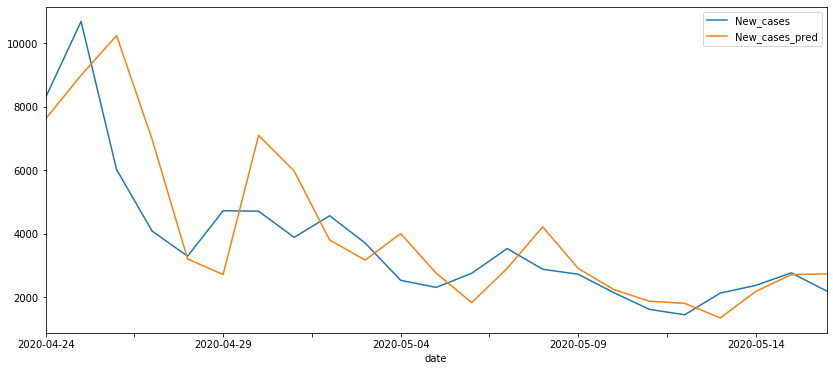

In [36]:
test['New_cases_pred'] = np.exp(pred)
test[['New_cases', 'New_cases_pred']].plot(figsize=(14,6))

In [37]:
arima_fit.forecast(3)[0]

array([7.91092936, 7.68481756, 7.70895174])

##However, once we go out of sample, the prediction grows exponatialy

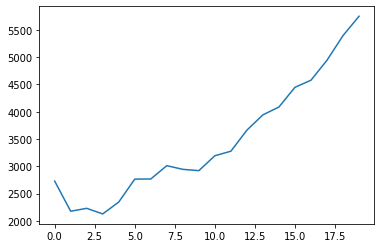

In [38]:
prediction_data=np.exp(arima_fit.forecast(steps=20)[0]) # We generated 20 days of out of sample prediction and the model behaved alright for about 12 days before going off-charts
plt.plot(prediction_data)

In [39]:
arima = ARIMA(train.New_cases_log.dropna().astype(float), order=(15,1,1))
arima_fit = arima.fit(disp=1, maxiter=100)

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



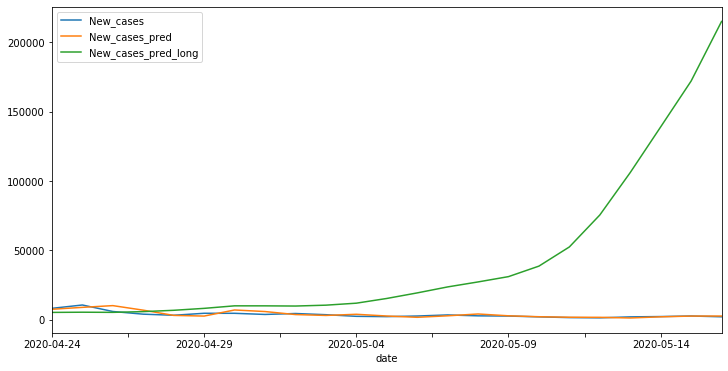

In [40]:
pred,_,_ = arima_fit.forecast(steps=len(test))
test['New_cases_pred_long'] = np.exp(pred)
test[['New_cases', 'New_cases_pred', 'New_cases_pred_long']].plot(figsize=(12,6))

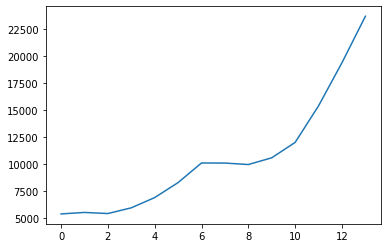

In [41]:
prediction_data=np.exp(arima_fit.forecast(steps=14)[0])
plt.plot(prediction_data)

## Prophet (Built by Facebook). This library required your dataframe to have a date column called 'ds' and a 'y' column containing the numeric data you want to fit the model with. Hence we do some manipulations with our dataframe to make sure it fits the requirement.

In [42]:
test_df=NY_df[['New_cases']] # Since the dataframe's index is the date, we only need the new cases column

In [43]:
test_df.rename(columns={'date':'ds','New_cases':'y'}, inplace=True)
test_df['ds']=test_df.index # Copied the index to the 'ds' date column as required by Propher

C:\Users\amg_m\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
test_df['ds']=pd.to_datetime(test_df['ds']) #Converting the data type to datetime just in case

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## We initialize the Prophet forecasting procedure below. Notice that there are two growth options, logistic, and linear. The logistic growth did not fit the needs of an epidimiological model hence we opted for the default linear option while enabling the MCMC parameter (Markov Chain Monte Carlo) which allows us to include seasonal uncertanties and a full Baysian sampling.

In [45]:
m=Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, mcmc_samples=300) #Initiated a Prophet instance, and disabling all three parameters of seasonality

In [46]:
m.fit(test_df) # Model is fit with the dataframe e.g. trained

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [47]:
future=m.make_future_dataframe(periods=90) # A very useful function which builds a new dataframe with future dates to integrate the forcasted data. Here we chose to go 30 days into the future.

In [48]:
forecast = m.predict(future) # We initiated forecasting and passed the future dataframe as a parameter
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds          yhat    yhat_lower   yhat_upper
162 2020-08-10 -13612.237292 -25426.195984 -2437.464617
163 2020-08-11 -13795.436822 -25391.733483 -2383.133152
164 2020-08-12 -13978.636351 -25460.255383 -2494.545285
165 2020-08-13 -14161.835881 -26538.789845 -2062.788141
166 2020-08-14 -14345.035411 -27113.510624 -2424.108025

In [49]:
forecast.head(-20)

ds         trend    yhat_lower   yhat_upper   trend_lower  \
0   2020-03-01  -1124.499514  -3432.424725  1273.271701  -1882.924837   
1   2020-03-02   -856.790723  -3153.037032  1469.583671  -1575.567133   
2   2020-03-03   -589.081931  -2889.443005  1762.215928  -1272.628870   
3   2020-03-04   -320.249523  -2736.160718  1947.773269   -973.785935   
4   2020-03-05    -51.417114  -2294.674085  2272.858642   -671.819153   
..         ...           ...           ...          ...           ...   
142 2020-07-21  -9948.246693 -18217.402815 -2056.859764 -17827.216947   
143 2020-07-22 -10131.446223 -18238.170998 -1993.713131 -18162.444424   
144 2020-07-23 -10314.645753 -18722.038769 -1889.476602 -18490.972714   
145 2020-07-24 -10497.845282 -19385.580964 -2134.172584 -18821.445525   
146 2020-07-25 -10681.044812 -19672.202088 -1960.190803 -19150.842780   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    -388.163044             0.0                   0.0                   0.0   
1    -162.024483             0.0                   0.0                   0.0   
2      65.321164             0.0                   0.0                   0.0   
3     306.156112             0.0                   0.0                   0.0   
4     565.985530             0.0                   0.0                   0.0   
..           ...             ...                   ...                   ...   
142 -2466.374627             0.0                   0.0                   0.0   
143 -2523.925619             0.0                   0.0                   0.0   
144 -2518.229740             0.0                   0.0                   0.0   
145 -2518.889735             0.0                   0.0                   0.0   
146 -2588.652850             0.0                   0.0                   0.0   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
142                   0.0                         0.0   
143                   0.0                         0.0   
144                   0.0                         0.0   
145                   0.0                         0.0   
146                   0.0                         0.0   

     multiplicative_terms_upper          yhat  
0                           0.0  -1124.499514  
1                           0.0   -856.790723  
2                           0.0   -589.081931  
3                           0.0   -320.249523  
4                           0.0    -51.417114  
..                          ...           ...  
142                         0.0  -9948.246693  
143                         0.0 -10131.446223  
144                         0.0 -10314.645753  
145                         0.0 -10497.845282  
146                         0.0 -10681.044812  

[147 rows x 13 columns]

## Below plot illustrates the actual data in purple dotted line while the solid lines represented the upper, lower, and mid y_hat (forecast) ranges generated by the Prophet.
## The sharp increase in cases and deaths on May 6th destabilized the model. This is caused by the NYT starting to report probable COVID-19 cases and deaths and not only the ones confirmed by testing.

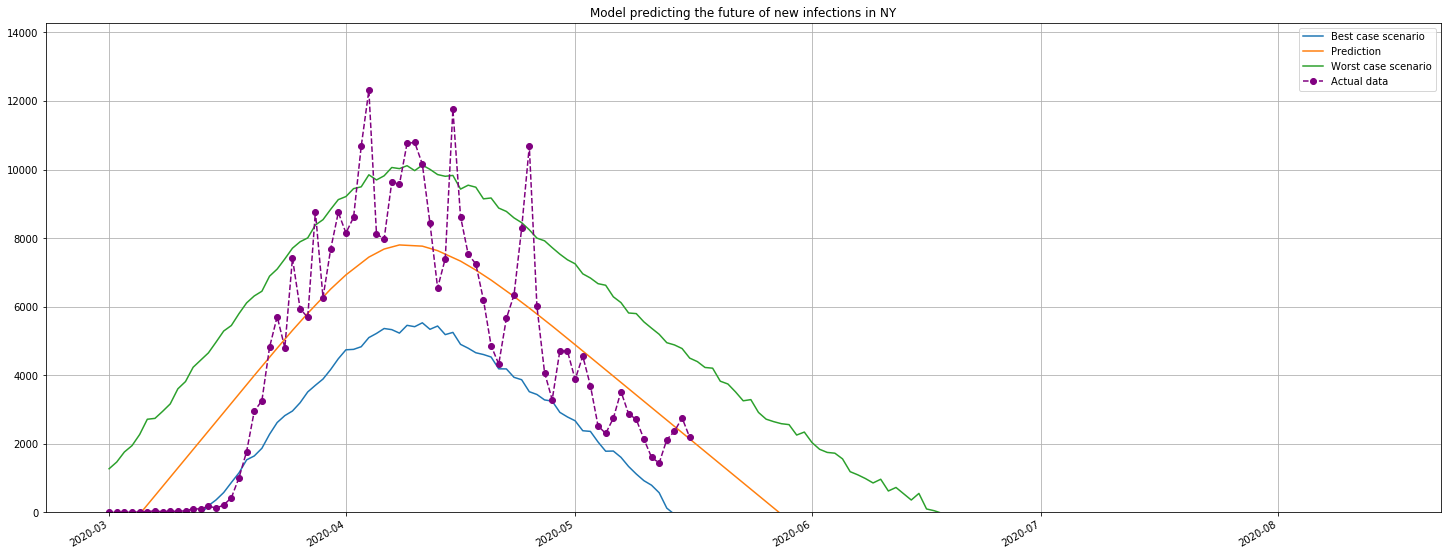

In [50]:
fig, ax=plt.subplots(figsize=(25,10))
plt.plot(pd.date_range(start='2020-03-01', periods=len(forecast), freq='D'), forecast.yhat_lower, label='Best case scenario')
plt.plot(pd.date_range(start='2020-03-01', periods=len(forecast), freq='D'),forecast.yhat, label='Prediction')
plt.plot(pd.date_range(start='2020-03-01', periods=len(forecast), freq='D'), forecast.yhat_upper, label='Worst case scenario')
plt.plot(pd.date_range(start='2020-03-01', periods=len(test_df), freq='D'), test_df.y,  'o--', label='Actual data', color='purple')
plt.title('Model predicting the future of new infections in NY')
plt.legend()
plt.grid()
#plt.hlines(y=0, xmin=0, xmax=len(future), color='red')
plt.ylim(bottom=0)
fig.autofmt_xdate()
plt.show()

## The below plot is built-in in the Prophet, it illustrates the same data

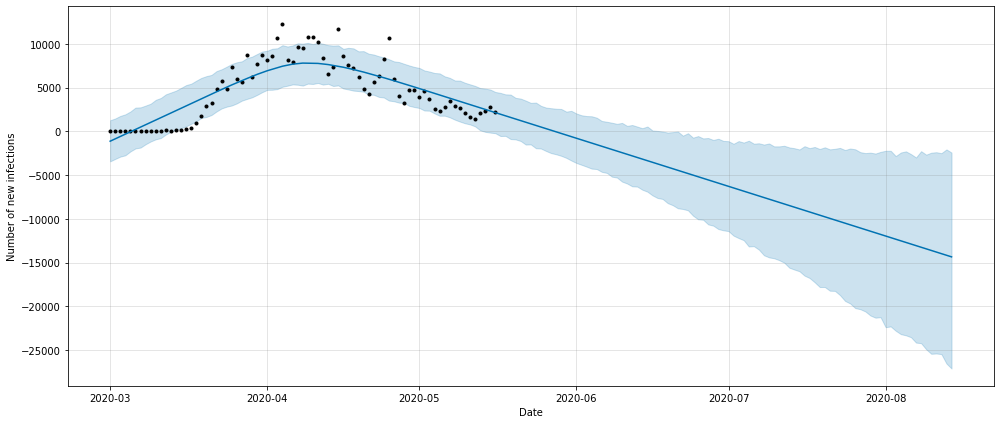

In [51]:
fig1=m.plot(forecast.iloc[:1500], figsize=(14,6), xlabel='Date', ylabel='Number of new infections')

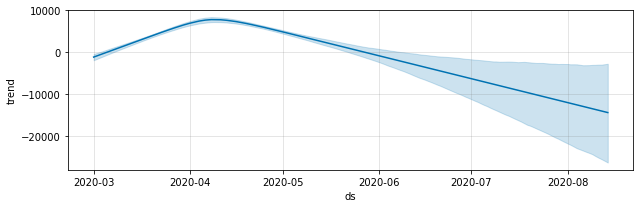

In [52]:
fig=m.plot_components(forecast)